In [23]:
#!pip install keras_cv

import tensorflow as tf
import tensorflow_datasets as tfds
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import tqdm

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Prepare the Dataset

In [24]:
#1. get mnist from tensorflow datasets
mnist = tfds.load("mnist", split=["train","test"], as_supervised=True)
train_ds = mnist[0]
val_ds = mnist[1]

def cumsum_dataset(ds, seq_len):
  ds = ds.map(lambda x, t: tf.cast(t, dtype=tf.dtypes.int32))
  ds = ds.window(seq_len)
  def alternating_scan_function(state, elem):
    old_sign = state
    new_sign = old_sign*-1
    signed_target = elem*old_sign
    out_elem = signed_target
    new_state = new_sign
    return new_state, out_elem
  ds = ds.map(lambda sub_ds: sub_ds.scan(initial_state=1, scan_func=alternating_scan_function))
  def scan_cum_sum_function(state, elem):
    sum_including_this_elem = state+elem
    return sum_including_this_elem, sum_including_this_elem
  ds = ds.map(lambda sub_dataset: sub_dataset.scan(initial_state=0, scan_func=scan_cum_sum_function))
  ds = ds.map(lambda sub_dataset: sub_dataset.batch(seq_len).get_single_element())
  return ds


#2. Preproces the data using the map method or scan
def preprocess(data, batch_size, sequence_length):
  data = data.map(lambda x, t: (tf.cast(x, dtype=tf.float32)/255., t))
  ds = data.batch(sequence_length)
  targets = data.apply(lambda dataset: cumsum_dataset(dataset, sequence_length))
  ds = tf.data.Dataset.zip((ds, targets))
  ds = ds.map(lambda img, target: (img[0], target))
  ds = ds.shuffle(2000).batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)

  return ds

train_ds = preprocess(train_ds, batch_size=32, sequence_length=4)
val_ds = preprocess(val_ds, batch_size=32, sequence_length=4)

(32, 4)
(32, 4, 28, 28, 1)
tf.Tensor([7 4 8 0], shape=(4,), dtype=int32)


2022-12-30 16:32:53.156645: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-30 16:32:53.162860: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 432x288 with 0 Axes>

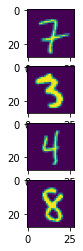

In [25]:
for img1, label in train_ds.take(1):
  print(label.shape)
  print(img1.shape)
  plt.figure()
  f, axarr = plt.subplots(4,1) 
  axarr[0].imshow(img1[0][0].numpy().squeeze())
  axarr[1].imshow(img1[0][1].numpy().squeeze())
  axarr[2].imshow(img1[0][2].numpy().squeeze())
  axarr[3].imshow(img1[0][3].numpy().squeeze())
  print(label[0])

### Optimise your model

In [26]:
class RNNCell(tf.keras.layers.AbstractRNNCell):

    def __init__(self, recurrent_units_1, recurrent_units_2, **kwargs):
        super().__init__(**kwargs)

        self.recurrent_units_1 = recurrent_units_1 # hidden state units
        self.recurrent_units_2 = recurrent_units_2 # cell state units
        
        self.linear_1 = tf.keras.layers.Dense(recurrent_units_1)
        self.linear_2 = tf.keras.layers.Dense(recurrent_units_2)
        
        # forget gate
        self.forget_gate = tf.keras.layers.Dense(recurrent_units_1, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None),
                                                       activation='sigmoid')
        # layer normalization for trainability
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        
        # input gate
        self.input_gate = tf.keras.layers.Dense(recurrent_units_1, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None), 
                                                       activation='sigmoid')
        # cell-state candidates
        self.cellstate_candidates = tf.keras.layers.Dense(recurrent_units_1, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None), 
                                                       activation=tf.nn.tanh)
        # output gate                                               
        self.output_gate = tf.keras.layers.Dense(recurrent_units_1, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None), 
                                                       activation='sigmoid')

        # layer normalization for trainability
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
    
    @property
    def state_size(self):
        return [tf.TensorShape([self.recurrent_units_1]), 
                tf.TensorShape([self.recurrent_units_2])]
    @property
    def output_size(self):
        return [tf.TensorShape([self.recurrent_units_2])]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros([self.recurrent_units_1]), 
                tf.zeros([self.recurrent_units_2])]

    def call(self, inputs, states):
        # unpack the states
        hidden_state = states[0]
        cell_state = states[1]
        
        # linearly project input
        x = self.linear_1(inputs) + hidden_state
        
        # apply forget gate
        forget_candidates = self.forget_gate(x)
        # apply layer norm
        #x = self.layer_norm_1(new_hidden_state)

        # apply input gate
        new_input = self.input_gate(x)
        new_candidates = self.cellstate_candidates(x)
        # apply layer norm
        #x = self.layer_norm_1(new_hidden_state)
        
        new_cell_state = forget_candidates * cell_state + new_input * new_candidates

        # output gate
        output= self.output_gate(x)
        new_hidden_state = output * tf.nn.tanh(new_cell_state)
        
        # return output and the list of new states of the layers
        return new_hidden_state, [new_hidden_state, new_cell_state]
    
    def get_config(self):
        return {"recurrent_units_1": self.recurrent_units_1, 
                "recurrent_units_2": self.recurrent_units_2}

In [27]:
class CNN_LSTMModel(tf.keras.Model):

  #1 Constructor
  def __init__(self, batch_size, sequence_len):
    super(CNN_LSTMModel, self).__init__()
    #optimizer, loss function and metrics
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    self.loss = tf.keras.losses.MeanAbsoluteError()
    self.metrics_list = [
                        tf.keras.metrics.MeanAbsoluteError(name="loss")
                        #tf.keras.metrics.Accuracy(name="acc")
                       ]

    input_shape = (batch_size, sequence_len, 28, 28, 1)

    self.rnn_cell = RNNCell(recurrent_units_1=24,
                                recurrent_units_2=24)
        

    self.layer_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]),
      tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]),
      tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
      #tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)),
      #tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]),
      #tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
      #tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]),
      #tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
      tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAvgPool2D()),
      tf.keras.layers.Dense(24, activation='softmax'),
      tf.keras.layers.RNN(self.rnn_cell, return_sequences=True, unroll=True),
      tf.keras.layers.Dense(1)
    ]

    #2. call method (forward computation)
  def call(self, x, training=False):
      for layer in self.layer_list[:-1]:
        x = layer(x)
      return self.layer_list[-1](x)

  #3. metrics property
  @property
  def metrics(self):
    # return a list with all metrics in the model
    return self.metrics_list


  #4 reset all metrics object
  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset_states()

  def train_step(self, data):
    sequence, label = data
    with tf.GradientTape() as tape:
      output = self(sequence, training=True)
      #loss = self.compiled_loss(label, output, regularization_losses=self.losses)
      loss = self.loss(label, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    #update metrics
    self.metrics[0].update_state(label, output)
    #self.metrics[1].update_state(label, output)
    return {m.name : m.result() for m in self.metrics}

  def test_step(self, data, return_predictions=False):
    sequence, label = data
    output = self(sequence, training=False)
    if return_predictions:
      print(output[0])
    #loss = self.compiled_loss(label, output, regularization_losses=self.losses)
    loss = self.loss(label, output)
    self.metrics[0].update_state(label, output)
    #self.metrics[1].update_state(label, output)
    return {m.name : m.result()  for m in self.metrics}

In [28]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_path = f"logs/train/"
val_log_path = f"logs/val/"
train_summary_writer = tf.summary.create_file_writer(train_log_path + current_time)
val_summary_writer = tf.summary.create_file_writer(val_log_path + current_time)

In [30]:
def visualisation(train_losses, train_acc, test_losses, test_acc):
  plt.figure ()
  line1, = plt.plot(train_losses , "b-" )
  line2, = plt.plot(test_losses , "r-" )
  plt.xlabel( " Training steps " )
  plt.ylabel( " Loss / Accuracy " )
  plt.legend((line1, line2), ("training loss", "test loss"))
  plt.show()

In [31]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path):
  train_loss = []
  val_loss = []
  train_acc = []
  val_acc = []

  #1. iterate over epochs
  for e in range(epochs):
    #2. train steps on all batchs in the training data
    for data in tqdm.tqdm(train_ds):
      metrics = model.train_step(data)
    # 3. log and print data metrics
    with train_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
    
    for (key, value) in metrics.items():
      #if key == 'acc':
        #train_acc.append(value.numpy())
      if key == 'loss':
        train_loss.append(value.numpy())

    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])

    #4 reset the metrics
    model.reset_metrics()

    #5. evaluate on validation data
    for data in val_ds:
      metrics = model.test_step(data)
    
    #6. log validation metrics
    with val_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
    
    for (key, value) in metrics.items():
      #if key == 'acc':
        #val_acc.append(value.numpy())
      if key == 'loss':
        val_loss.append(value.numpy())


    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
    #7. reset metric objects
    model.reset_metrics()

  model.save_weights(save_path)
  return train_loss, val_loss, train_acc, val_acc

**Training model without regularisation**

In [32]:
model = CNN_LSTMModel(batch_size=32, sequence_len=4)
epochs=15

#2. choose a path to save the weights
save_path = "trained_model"

train_loss, val_loss, train_acc, val_acc = training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path)


100%|██████████| 469/469 [01:17<00:00,  6.07it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 3.823650598526001']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 3.600949287414551']


100%|██████████| 469/469 [01:20<00:00,  5.83it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.319366693496704']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 3.0722246170043945']


100%|██████████| 469/469 [01:22<00:00,  5.66it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.6866123676300049']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 3.0516741275787354']


100%|██████████| 469/469 [01:18<00:00,  5.95it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.5452830791473389']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.7526381015777588']


100%|██████████| 469/469 [01:19<00:00,  5.93it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.4445877075195312']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.9030367136001587']


100%|██████████| 469/469 [01:19<00:00,  5.87it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.3611540794372559']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.955135703086853']


100%|██████████| 469/469 [01:19<00:00,  5.89it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.273972511291504']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.5738064050674438']


100%|██████████| 469/469 [01:19<00:00,  5.89it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.2198922634124756']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.3275976181030273']


100%|██████████| 469/469 [01:19<00:00,  5.87it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.1591646671295166']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.412667989730835']


100%|██████████| 469/469 [01:19<00:00,  5.90it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.131697416305542']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.396078109741211']


100%|██████████| 469/469 [01:20<00:00,  5.82it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.0731641054153442']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.3668912649154663']


100%|██████████| 469/469 [01:20<00:00,  5.80it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.0395866632461548']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 3.321593761444092']


100%|██████████| 469/469 [01:20<00:00,  5.81it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.013696551322937']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.5229064226150513']


100%|██████████| 469/469 [01:19<00:00,  5.91it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 0.9761881232261658']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.6976392269134521']


100%|██████████| 469/469 [01:19<00:00,  5.89it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 0.9467750787734985']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.2526384592056274']


100%|██████████| 469/469 [01:19<00:00,  5.88it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 0.9257831573486328']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.1585323810577393']


100%|██████████| 469/469 [01:19<00:00,  5.89it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 0.8974609375']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.8095703125']


100%|██████████| 469/469 [01:19<00:00,  5.90it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 0.8668899536132812']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 2.1140661239624023']


100%|██████████| 469/469 [01:20<00:00,  5.81it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 0.8507105112075806']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.3142800331115723']


100%|██████████| 469/469 [01:08<00:00,  6.83it/s]


MeanAbsoluteError(name=loss,dtype=float32)
['loss: 0.8265340328216553']
MeanAbsoluteError(name=loss,dtype=float32)
['loss: 1.7863519191741943']


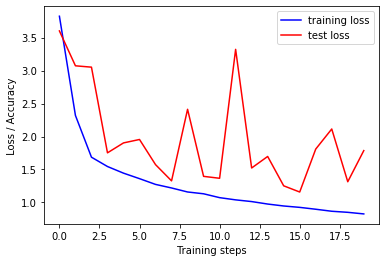

In [33]:
visualisation(train_loss, train_acc, val_loss, val_acc)

(32, 4)
(32, 4, 28, 28, 1)
tf.Tensor([ 4 -1 -1 -3], shape=(4,), dtype=int32)
tf.Tensor(
[[ 5.319496  ]
 [ 0.03693405]
 [ 2.7953842 ]
 [-2.7309043 ]], shape=(4, 1), dtype=float32)


<Figure size 432x288 with 0 Axes>

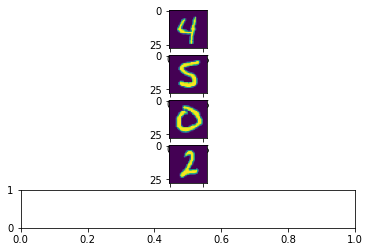

In [34]:
for img1, label in val_ds.take(1):
  print(label.shape)
  print(img1.shape)
  plt.figure()
  f, axarr = plt.subplots(5,1) 
  axarr[0].imshow(img1[0][0].numpy().squeeze())
  axarr[1].imshow(img1[0][1].numpy().squeeze())
  axarr[2].imshow(img1[0][2].numpy().squeeze())
  axarr[3].imshow(img1[0][3].numpy().squeeze())
  print(label[0])
  model.test_step((img1,label), return_predictions=True)